In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import pickle 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis.sklearn
import pyLDAvis
pyLDAvis.enable_notebook()

from collections import defaultdict

In [2]:
df = pd.read_csv('../data/final_legal_df.csv', index_col=0)

In [3]:
df.head()

case_id  decision_date  case_citation_name                     court  \
0  2747110           1771  2 Ill. App. 3d 538  Illinois Appellate Court   
1   435537           1819           1 Ill. 21    Illinois Supreme Court   
2   435638           1819           1 Ill. 19    Illinois Supreme Court   
3   435690           1819           1 Ill. 17    Illinois Supreme Court   
4   435710           1819           1 Ill. 19    Illinois Supreme Court   

                                        citations  \
0  ['1 and 119', '89 S.Ct. 2100', '395 U.S. 959']   
1                                             NaN   
2                                 ['2 Dall, 302']   
3                                             NaN   
4                                             NaN   

                                          clean_text  \
0  mr presiding justice eberspacher delivered opi...   
1  opinion court wa criminal prosecution riot pla...   
2  opinion court wa action debt judgment rendered...   
3  opinion court wa action covenant fifth plea st...   
4  opinion court appears record cause writ issued...   

                                            keywords  \
0  ['sentenced', 'sentence', 'sentencing', 'court...   
1  ['indictment', 'form', 'criminal', 'shall', 'y...   
2     ['action', 'court', 'judgment', 'plea', 'nil']   
3   ['plea', 'court', 'post', 'failure', 'illinois']   
4  ['court appears', 'scam', 'appearance', 'appea...   

                                               summs  d2v_scores  lda_preds  \
0  The court entered judgment upon the verdict an...    1.306400          4   
1  This was a criminal prosecution for a riot, ag...    1.451599          4   
2  Opinion of the Court.This was an action of deb...    0.455963          3   
3  Opinion of the Court.This was an action of cov...    0.994830          3   
4  It appears from the record in this cause, that...    0.522237          3   

   lda_sub_group  
0             13  
1             12  
2              9  
3              9  
4              9

In [4]:
article_citations = []

for item in df.citations:
    
    item_cite = []
    
    
    try:
        item_cite.extend(re.findall(r'\d+\sIll.\s\dd\s\d+', item)) 
    except:
        pass
    
    
    try:
        item_cite.extend(re.findall(r'\d+\sIll.\s\d+', item))  
    except:
        pass
    
    
    try:
        item_cite.extend(re.findall(r'\d+\sIll.\sApp.\s\dd\s\d+', item))  
    except:
        pass
    
    cite = [name for name in item_cite if not name.endswith(' 2')]
    article_citations.append(list(set(cite)))

In [5]:
df['citations'] = article_citations

In [6]:
df.iloc[144961]['citations']

['72 Ill. App. 3d 37',
 '12 Ill. App. 3d 559',
 '117 Ill. App. 3d 782',
 '38 Ill. 2d 80',
 '12 Ill. 2d 547',
 '47 Ill. 2d 541',
 '113 Ill. App. 3d 1091',
 '63 Ill. 2d 71',
 '76 Ill. 2d 385']

In [7]:
df['citations'] = df.citations.apply(lambda citations: np.nan if citations==[] else citations)

In [8]:
df.citations.isna().sum()

80048

In [9]:
df.shape

(183149, 11)

In [10]:
df = df.dropna(subset=['citations'])

In [11]:
df.shape

(103101, 11)

In [12]:
df.head()

case_id  decision_date case_citation_name                   court  \
22     435549           1822          1 Ill. 54  Illinois Supreme Court   
41     435612           1823          1 Ill. 66  Illinois Supreme Court   
168    435541           1831         1 Ill. 401  Illinois Supreme Court   
1512  2579647           1850        12 Ill. 173  Illinois Supreme Court   
1562  2580284           1851         13 Ill. 59  Illinois Supreme Court   

          citations                                         clean_text  \
22     [24 Ill, 60]  opinion court justice john eeynolds william no...   
41     [15 Ill, 56]  opinion court justice john reynolds although a...   
168   [13 Ill. 599]  smith j delivered opinion court appellant reli...   
1512  [11 Ill, 624]  caton j case called upon decide upon effect ju...   
1562  [11 Ill. 332]  trumbull j waiving decision constitutional que...   

                                               keywords  \
22    ['person', 'personal', 'opinion court', 'wit',...   
41    ['continuance', 'continued', 'copy', 'declarat...   
168   ['execution', 'court', 'declaration', 'declare...   
1512   ['judgment', 'form', 'court', 'statute', 'land']   
1562    ['state', 'bond', 'person', 'section', 'negro']   

                                                  summs  d2v_scores  \
22    2. David Rankin, the person intended to be inj...    1.229429   
41    Opinion of the Court byJustice John Reynolds.A...    0.862796   
168   The error as alleged in sustaining the demurre...    0.536514   
1512  This form contains certain recitals, after whi...   -0.750508   
1562  The first section declares, that “ no black or...    1.151486   

      lda_preds  lda_sub_group  
22            3              8  
41            3              9  
168           3              9  
1512          3              9  
1562          3              8

In [18]:
law_citations_df = df[['case_citation_name', 'citations', 'lda_preds', 'lda_sub_group']]

In [19]:
law_citations_df = law_citations_df.reset_index()
law_citations_df = law_citations_df.drop(columns=['index'])

In [20]:
law_citations_df.head()

case_citation_name      citations  lda_preds  lda_sub_group
0          1 Ill. 54   [24 Ill, 60]          3              8
1          1 Ill. 66   [15 Ill, 56]          3              9
2         1 Ill. 401  [13 Ill. 599]          3              9
3        12 Ill. 173  [11 Ill, 624]          3              9
4         13 Ill. 59  [11 Ill. 332]          3              8

In [21]:
law_citations_df.shape

(103101, 4)

In [22]:
law_citations_df['citations'][0]

['24 Ill, 60']

# Graph Theory

In [23]:
graph = dict(zip(df.case_citation_name, df.citations))

In [24]:
def generate_edges(graph):
    
    edges = []
    
    for node in graph:
        try:
            for neighbour in graph[node]:
                edges.append((node, neighbour))
        except:
            pass
    return edges

In [25]:
edges = generate_edges(graph)

In [26]:
edges = list(set(edges))

In [27]:
edges[:10]

[('54 Ill. App. 3d 987', '60 Ill. App. 2d 396'),
 ('67 Ill. App. 3d 687', '59 Ill. App. 3d 563'),
 ('104 Ill. App. 3d 728', '95 Ill. App. 3d 5'),
 ('139 Ill. App. 3d 68', '5 Ill. App. 3d 484'),
 ('59 Ill. App. 3d 71', '66 Ill. 2d 276'),
 ('249 Ill. App. 337', '318 Ill. 432'),
 ('90 Ill. App. 3d 800', '71 Ill. 2d 480'),
 ('86 Ill. App. 3d 845', '67 Ill. App. 3d 21'),
 ('41 Ill. App. 3d 249', '60 Ill. 2d 204'),
 ('42 Ill. App. 3d 608', '53 Ill. 2d 388')]

# Creating a Graph with Networkx

In [28]:
import networkx as nx

In [29]:
G = nx.DiGraph()
G.add_edges_from(edges)

print(G.number_of_edges())
print(G.number_of_nodes())

624229
131659


In [30]:
deg = dict(G.degree())

In [31]:
to_remove = [n for n in deg if deg[n] == 1]

In [32]:
len(to_remove)

24203

In [33]:
G.remove_nodes_from(to_remove)

In [34]:
G.number_of_nodes()

107456

In [35]:
while len(to_remove) > 0:
    deg = dict(G.degree())
    to_remove = [n for n in deg if deg[n] == 1]
    print(f'removing {len(to_remove)} nodes')
    G.remove_nodes_from(to_remove)
    print(f'there are {G.number_of_nodes()} nodes')

removing 1137 nodes
there are 106319 nodes
removing 99 nodes
there are 106220 nodes
removing 14 nodes
there are 106206 nodes
removing 0 nodes
there are 106206 nodes


In [ ]:
pos=nx.spring_layout(G)

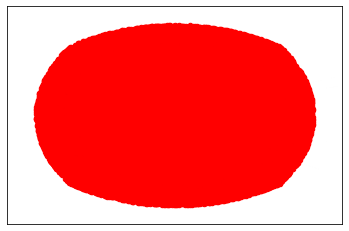

In [84]:
nx.draw_networkx(G, pos, edges=True, with_labels=False, node_size=20, width=.1, node_color='red', edge_color = 'black')
plt.show()

In [93]:
#most cited cases
sorted(deg.items(), key = lambda x: x[1], reverse=True)[:10]

[('66 Ill. 2', 2205),
 ('63 Ill. 2', 2053),
 ('68 Ill. 2', 1895),
 ('79 Ill. 2', 1835),
 ('37 Ill. 2', 1778),
 ('74 Ill. 2', 1770),
 ('82 Ill. 2', 1681),
 ('60 Ill. 2', 1638),
 ('54 Ill. 2', 1614),
 ('76 Ill. 2', 1569)]

In [95]:
cases_cited_over_100 = [n for n in deg if deg[n] > 100] 
len(cases_cited_over_100)

165

In [96]:
[case for case in cases_cited_over_100 if case in df.case_citation_name]

[]

In [100]:
df[df.case_citation_name == '66 Ill. 23']

case_id  decision_date case_citation_name                   court  \
7956  2624460           1872         66 Ill. 23  Illinois Supreme Court   

          citations                                         clean_text  \
7956  [54 Ill. 157]  mr justice breese delivered opinion court posi...   

                                               keywords  \
7956  ['appellees', 'lease', 'fixture', 'act', 'appe...   

                                                  summs  d2v_scores  \
7956  Mr. Justice Breesedelivered the opinion of the...    0.544591   

      lda_preds  lda_sub_group  
7956          3             10

# Graphs by LDA groupings

In [125]:
df['lda_preds'].value_counts()

3    41502
5    15437
4    15396
1    15225
2    11327
Name: lda_preds, dtype: int64

In [126]:
df_lda1 = df[df.lda_preds == 1]

In [127]:
df_lda1 = df_lda1[['case_citation_name', 'citations']]

In [128]:
graph1 = dict(zip(df_lda1.case_citation_name, df_lda1.citations))

In [129]:
edges1 = generate_edges(graph1)

In [130]:
edges1 = list(set(edges1))

In [131]:
G1 = nx.DiGraph()
G1.add_edges_from(edges1)

G1.number_of_edges()

55999

In [151]:
deg1 = dict(G1.degree())
to_remove = [n for n in deg1 if deg1[n] == 1]

In [152]:
len(to_remove)

0

In [153]:
G1.remove_nodes_from(to_remove)

In [58]:
pos=nx.spring_layout(G1)

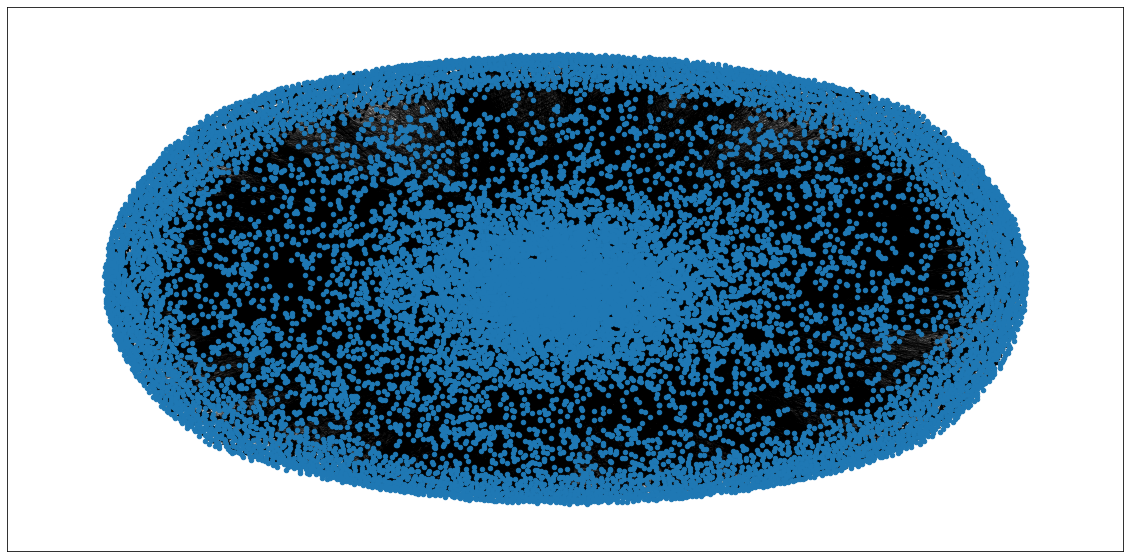

In [59]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G1, pos, edges=True, with_labels=False, node_size=20, width=.1, cmap='magma', edge_color = 'black')
plt.show()

In [64]:
deg1 = dict(G1.degree())
to_remove = [n for n in deg if deg[n] < 20]

In [65]:
G1.remove_nodes_from(to_remove)

In [66]:
pos=nx.spring_layout(G1)

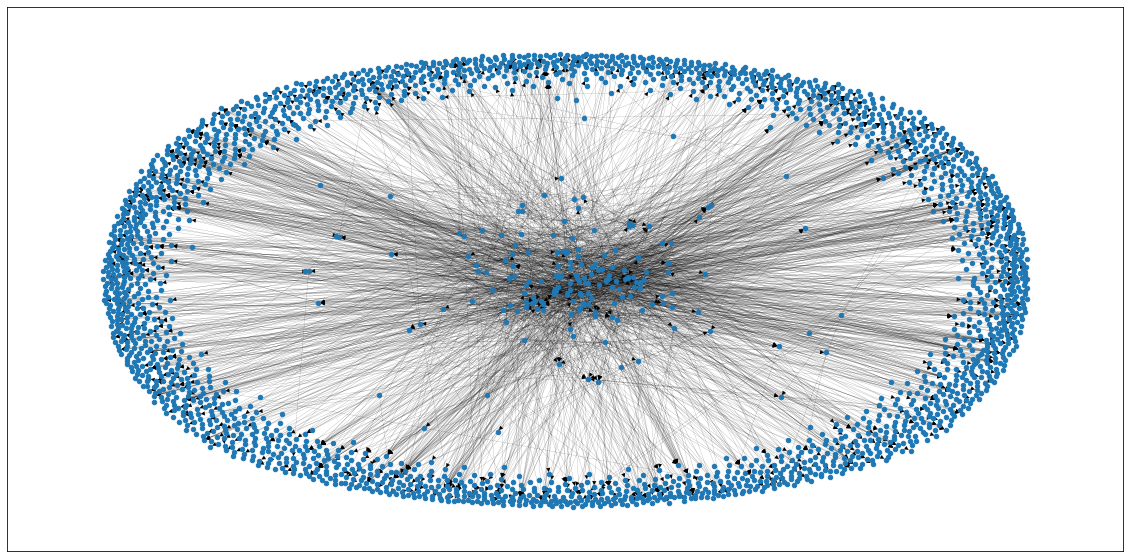

In [67]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G1, pos, edges=True, with_labels=False, node_size=20, width=.1, cmap='magma', edge_color = 'black')
plt.show()

In [70]:
def directed_graph_by_lda_group(group_num):
    
    new_df = df[df.lda_preds == group_num]
    new_df = new_df[['case_citation_name', 'citations']]
    new_graph = dict(zip(new_df.case_citation_name, new_df.citations))
    
    new_edges = generate_edges(new_graph)
    new_edges = list(set(new_edges))
    
    new_G = nx.DiGraph()
    new_G.add_edges_from(new_edges)
    print(new_G.number_of_edges())
    
    deg_dict = dict(new_G.degree())
    remove_list = [n for n in deg_dict if deg_dict[n] < 5]
    print(len(remove_list))
    new_G.remove_nodes_from(remove_list)
    
    new_pos = nx.spring_layout(new_G)
    
    plt.figure(figsize=(20,10))
    nx.draw_networkx(new_G, pos=new_pos, edges=True, with_labels=False, node_size=20, width=.1, cmap='magma', node_color='black', edge_color = 'red')
    plt.show()

44173
13901


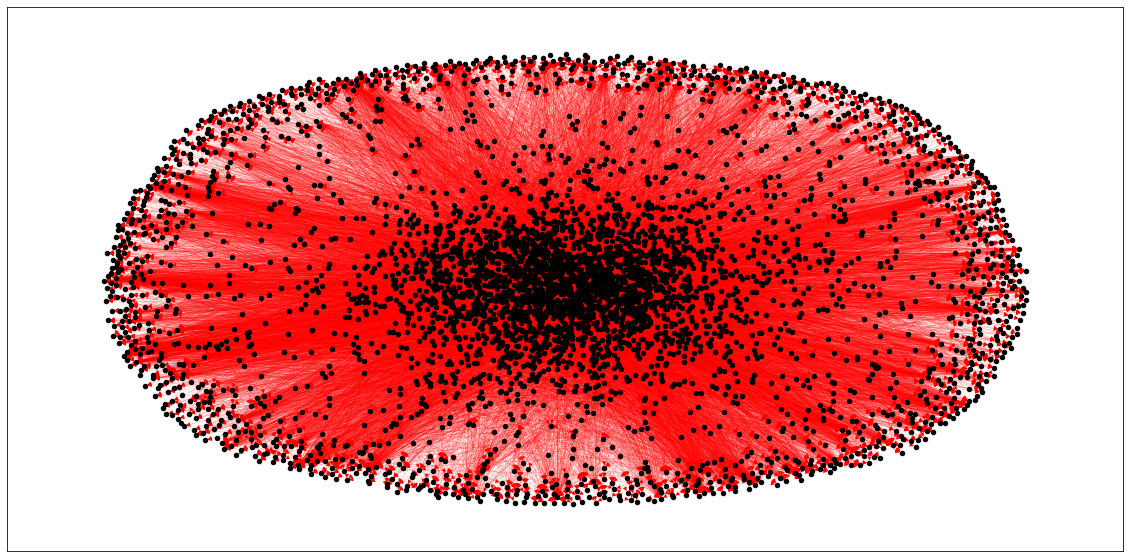

In [71]:
directed_graph_by_lda_group(2)

166048
34159


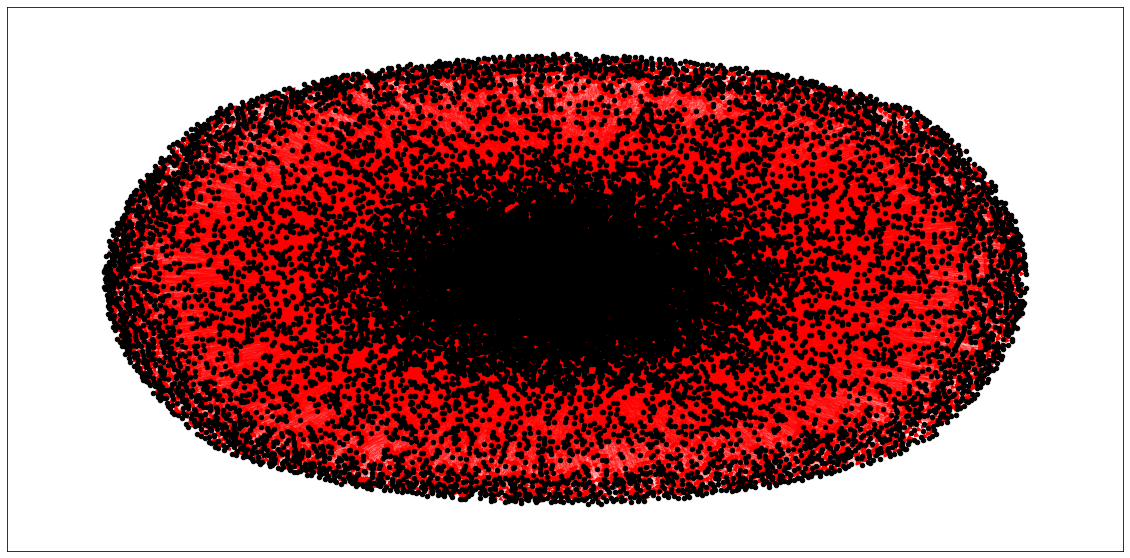

In [72]:
directed_graph_by_lda_group(3)

8353
6779


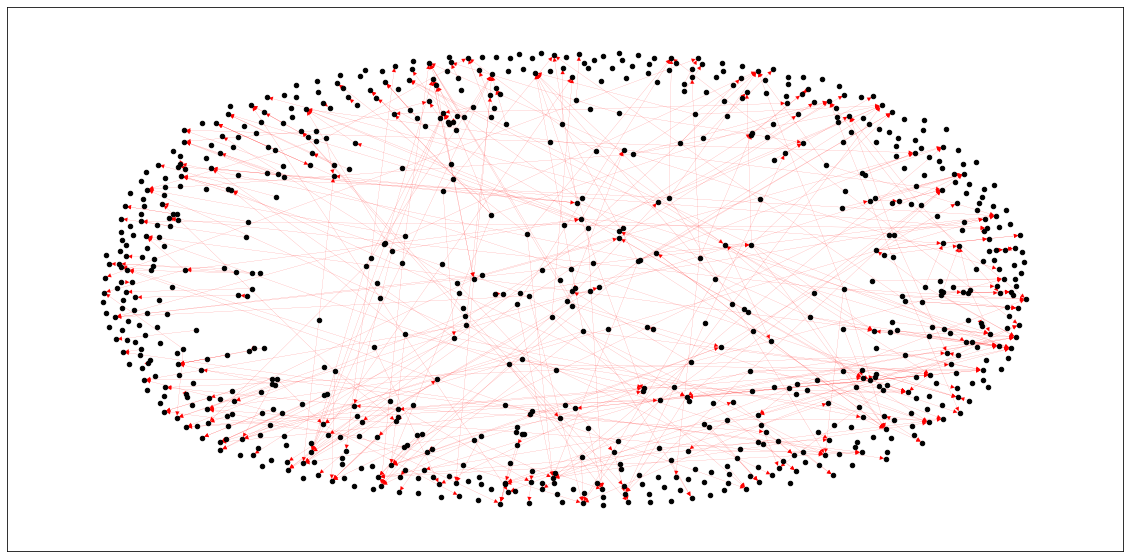

In [342]:
directed_graph_by_lda_group(4)

9940
5382


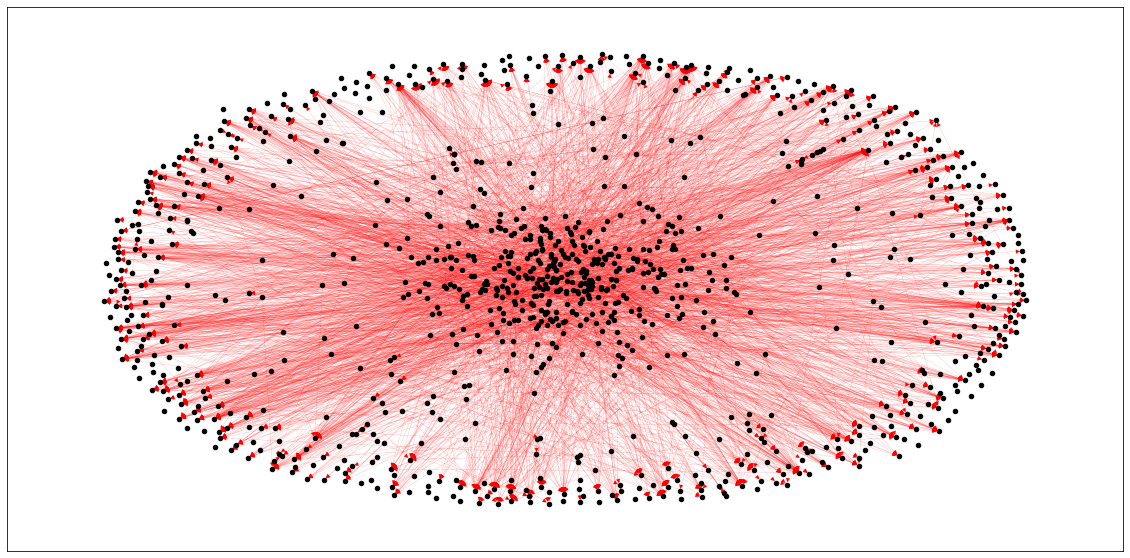

In [343]:
directed_graph_by_lda_group(5)

In [105]:
lda_df.head(2)

case_id  decision_date case_citation_name                   court  \
3412   443688           1860        25 Ill. 138  Illinois Supreme Court   
4177   425838           1863        40 Ill. 126  Illinois Supreme Court   

          citations                                         clean_text  \
3412   [11 Ill. 17]  caton c j affidavit continuance may insufficie...   
4177  [19 Ill. 229]  per curiam case people ex rel billing v bissel...   

                                               keywords  \
3412  ['court', 'defendant', 'judgment', 'ill', 'case']   
4177    ['motion writ', 'governor', 'case', 'argument']   

                                                  summs  d2v_scores  \
3412  Caton, C. J.\nThe affidavit for a continuance ...    0.856213   
4177  Per Curiam :\nThe case of The People ex rel. B...    0.378325   

      lda_preds  lda_sub_group  
3412          1              2  
4177          1              2

In [122]:
def directed_graph_by_lda_group(sub_group_num):
    
    new_df = lda_df[lda_df.lda_sub_group == sub_group_num]
    new_df = new_df[['case_citation_name', 'citations']]
    new_graph = dict(zip(new_df.case_citation_name, new_df.citations))
    
    new_edges = generate_edges(new_graph)
    new_edges = list(set(new_edges))
    
    new_G = nx.DiGraph()
    new_G.add_edges_from(new_edges)
    print(new_G.number_of_edges())
    
    deg_dict = dict(new_G.degree())
    remove_list = [n for n in deg_dict if deg_dict[n] < 5]
    print(len(remove_list))
    new_G.remove_nodes_from(remove_list)
    
    new_pos = nx.spring_layout(new_G)
    
    plt.figure(figsize=(20,10))
    nx.draw_networkx(new_G, pos=new_pos, edges=True, with_labels=False, node_size=20, width=.1, cmap='magma', node_color='black', edge_color = 'red')
    plt.show()

11446
4977


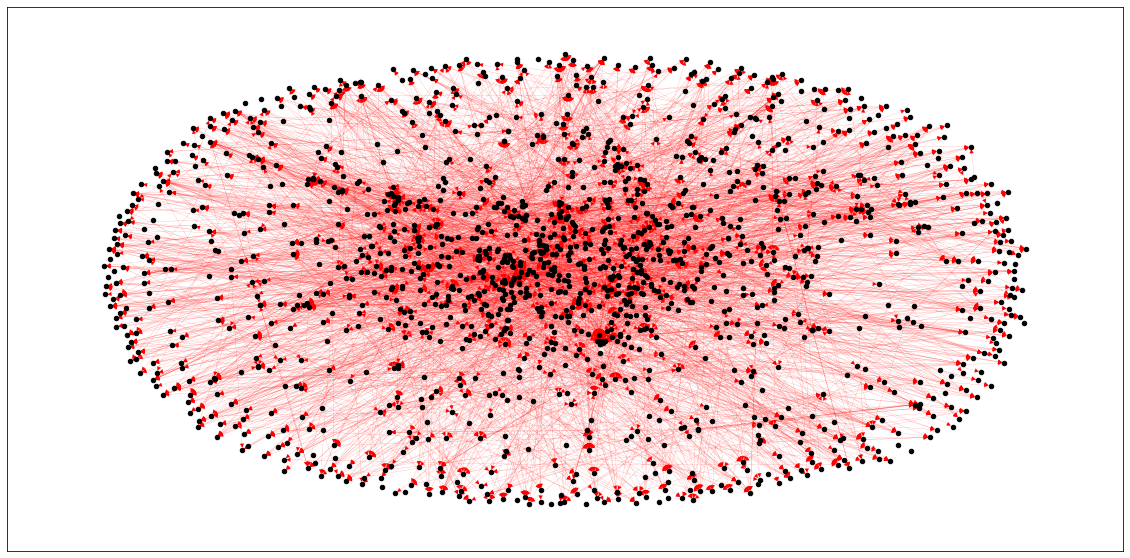

In [124]:
directed_graph_by_lda_group(13)

In [155]:
lda_df.head()

case_id  decision_date        case_citation_name  \
3412    443688           1860               25 Ill. 138   
4177    425838           1863               40 Ill. 126   
11142  4792909           1878  3 Ill. Cir. Ct. Rep. 524   
11153  4798077           1878   2 Ill. Cir. Ct. Rep. 34   
11166  4800034           1878   2 Ill. Cir. Ct. Rep. 41   

                        court      citations  \
3412   Illinois Supreme Court   [11 Ill. 17]   
4177   Illinois Supreme Court  [19 Ill. 229]   
11142  Illinois Circuit Court  [88 Ill. 498]   
11153  Illinois Circuit Court  [91 Ill. 611]   
11166  Illinois Circuit Court  [85 Ill. 304]   

                                              clean_text  \
3412   caton c j affidavit continuance may insufficie...   
4177   per curiam case people ex rel billing v bissel...   
11142  scott j application extension time part appell...   
11153  dickey j motion case made dismiss appeal wa fo...   
11166  craig j petition rehearing ha examined court s...   

                                                keywords  \
3412   ['court', 'defendant', 'judgment', 'ill', 'case']   
4177     ['motion writ', 'governor', 'case', 'argument']   
11142          ['time', 'addition allowed rule', 'file']   
11153        ['motion case', 'error clerk', 'overruled']   
11166  ['petition', 'judgment', 'correct expression',...   

                                                   summs  d2v_scores  \
3412   Caton, C. J.\nThe affidavit for a continuance ...    0.856213   
4177   Per Curiam :\nThe case of The People ex rel. B...    0.378325   
11142  Scott, J.:—\nAn application for an extension o...    0.986927   
11153  Dickey, J.:—\nA motion in this case is made to...    0.699820   
11166  Craig, J,:—\nThere is a petition for a reheari...    0.689649   

       lda_preds  lda_sub_group  
3412           1              2  
4177           1              2  
11142          1              2  
11153          1              2  
11166          1              3

In [159]:
graph['11 Ill. 17']

KeyError: '11 Ill. 17'

In [165]:
df[df.case_citation_name == '16 Ill. 405']

case_id  decision_date case_citation_name                   court  \
2181  2590709           1855        16 Ill. 405  Illinois Supreme Court   

                                   citations  \
2181  [15 Ill. 425, 15 Ill. 229, 11 Ill. 17]   

                                             clean_text  \
2181  skinner j william mcmaster wife sued spencer s...   

                                               keywords  \
2181  ['court case word', 'defendant', 'defend', 'sp...   

                                                  summs  d2v_scores  lda_preds  
2181  Spencer moved for a new trial, assigning for c...    2.391896          3

In [171]:

same_citations = []
for key, value in graph.items():
    if '11 Ill. 17' in value:
        same_citations.append(key)



In [172]:
same_citations

['13 Ill. 691',
 '16 Ill. 405',
 '25 Ill. 138',
 '32 Ill. 221',
 '82 Ill. 322',
 '16 Ill. App. 17',
 '51 Ill. App. 175',
 '158 Ill. App. 146']

In [ ]:
for key, value in graph.items():
    if '25 Ill. 138' in value:
        print(key)
        
sp = nx.all_pairs_shortest_path(graph)
sp['b']['d']


In [222]:
def find_all_paths(graph, start, end, path =[]): 
    
    path = path + [start] 
    
    if start == end: 
        return [path] 
    
    paths = [] 
    
    for node in graph[start]: 
        if node not in path: 
            newpaths = find_all_paths(graph, node, end, path) 
        for newpath in newpaths: 
            paths.append(newpath) 

    return paths 

In [223]:
print(find_all_paths(graph, '31 Ill. 153', '24 Ill. 623'))

KeyError: '13 Ill. 671'

In [87]:
# legal_cases = df.case_citation_name.tolist()

In [98]:
# law_citations_dictionary = dict.fromkeys(legal_cases, 0)

In [73]:
# legal_citations_dict = df.citations.to_dict()
# legal_citations_dict

{0: nan,
 1: nan,
 2: nan,
 3: nan,
 4: nan,
 5: "['1 Scam. 266']",
 6: "['13 Edward 1']",
 7: nan,
 8: nan,
 9: "['3 Wend. 418', '4 Wend. 514', '11 Wend. 83']",
 10: nan,
 11: "['0 Peters 478', '6 Peters 729', '4 Peters 47']",
 12: nan,
 13: nan,
 14: "['7 Mass. 186', '17 Johns. 446']",
 15: "['2 Scam. 78', '4 Scam. 547', '3 Scam. 193']",
 16: "['1836 and 1837', '1 Gall. 630', '107 to 115', '1 Metc. 212', '3 Pick. 149', '7 Peters, 464', '11 Mass. 475', '10 Johns. 129', '3 Scam. 305', '4 Pick. 253', '5 do. 393', '1 Dana, 166', '4 Bibb, 78', '4 Paige, 220', '8 Wend. 620', '15 Wend. 588', '13 Johns. 471', '11 Johns. 230', '8 Wend. 628', '13 Johns. 471', '15 Wend. 594', '6 Wend. 226', '4 Pick. 252', '3 do. 149', '1 Metc. 212', '10 Pick. 72', '7 Peters, 464', '11 Mass. 475', '1 Metc. 214', '2 Scam. 499']",
 17: "['10 Peters, 257', '10 Johns. 587', '3 Metcalf, 255', '11 Wend. 312']",
 18: "['3 Scam. 536', '19 Johns. 324', '18 Johns. 493']",
 19: nan,
 20: "['3 Scam. 347']",
 21: nan,
 22: "

In [ ]:
data[data.decision_year == 1979]
data[data.judge_name == 'mr. justice guild']

In [ ]:
graph = { "a" : ["c"],
          "b" : ["c", "e"],
          "c" : ["a", "b", "d", "e"],
          "d" : ["c"],
          "e" : ["c", "b"],
          "f" : []
        } 

In [ ]:
def generate_edges(graph):
    
    edges = []
    
    for node in graph:
        for neighbour in graph[node]:
            edges.append((node, neighbour))
            
    return edges

In [ ]:
generate_edges(graph)

In [ ]:
graph ={ 
'a':['c'], 
'b':['d'], 
'c':['e'], 
'd':['a', 'd'], 
'e':['b', 'c'] 
} 

In [ ]:
def find_path(graph, start, end, path =[]): 
    path = path + [start] 
    if start == end: 
        return path 
    for node in graph[start]: 
        if node not in path: 
            newpath = find_path(graph, node, end, path) 
            if newpath:  
                return newpath 
    
    return None

In [ ]:
print(find_path(graph, 'd', 'c'))

In [ ]:
def find_all_paths(graph, start, end, path =[]): 
    
    path = path + [start] 
    
    if start == end: 
        return [path] 
    
    paths = [] 
    
    for node in graph[start]: 
        if node not in path: 
            newpaths = find_all_paths(graph, node, end, path) 
        for newpath in newpaths: 
            paths.append(newpath) 

    return paths 

In [ ]:
print(find_all_paths(graph, 'd', 'c'))

In [ ]:
# function to find the shortest path 
def find_shortest_path(graph, start, end, path =[]): 
    path = path + [start] 
    
    if start == end: 
        return path 
    
    shortest = None
    for node in graph[start]: 
        if node not in path: 
            newpath = find_shortest_path(graph, node, end, path) 
                
            if newpath: 
                if not shortest or len(newpath) < len(shortest): 
                    shortest = newpath 
        return shortest 

In [ ]:
find_shortest_path(graph, 'd', 'c')

In [ ]:
graph = defaultdict(list)

def add_edge(graph, u, v):
    graph[u].append(v)

def generate_edges(graph):
    
    edges = []
    
    for node in graph:
        for neighbour in graph[node]:
            edges.append((node, neighbour))
            
    return edges